# Notebook 2 — Model Training

**Two-phase training strategy:**
1. **Phase 1** — Frozen VGG-16 image encoder; train only the tabular encoder + fusion classifier (~15–20 epochs).
2. **Phase 2** — Full fine-tuning of the entire model with a lower learning rate (~20–30 epochs).

**Inputs:** split CSVs and preprocessed `.pt` images from Notebook 1.

**Outputs:** `checkpoints/best_fusion_model.pth`

In [36]:
import os, sys, warnings, time
warnings.filterwarnings('ignore')

# ── MPS / Apple Silicon env vars (set BEFORE importing torch) ────────────
os.environ.setdefault("PYTORCH_MPS_HIGH_WATERMARK_RATIO", "0.0")   # use all unified memory
os.environ.setdefault("PYTORCH_ENABLE_MPS_FALLBACK", "1")          # CPU fallback for unsupported ops
# ─────────────────────────────────────────────────────────────────────────

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

# --- Project paths ---
NOTEBOOK_DIR  = os.path.dirname(os.path.abspath('__file__'))
PROJECT_ROOT  = os.path.abspath(os.path.join(NOTEBOOK_DIR, '..', '..'))
TRANSFORMED   = os.path.join(NOTEBOOK_DIR, 'transformedDataset')
CHECKPOINT_DIR = os.path.join(NOTEBOOK_DIR, 'checkpoints')
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

sys.path.insert(0, os.path.abspath(NOTEBOOK_DIR))

from utils.dataset import MultimodalDataset
from utils.models import FusionModel
from utils.training import (
    compute_class_weights,
    train_one_epoch,
    validate,
    EarlyStopping,
    setup_apple_silicon,
    mps_sync,
)

# --- Apple Silicon optimisations ---
setup_apple_silicon()
torch.set_float32_matmul_precision('high')   # faster matmuls where supported

# --- Device ---
if torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
    print(f'Apple Silicon GPU detected — using MPS backend')
elif torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print(f'Using device : {DEVICE}')
print(f'PyTorch      : {torch.__version__}')

Apple Silicon GPU detected — using MPS backend
Using device : mps
PyTorch      : 2.10.0


## Step 1 — Load Split CSVs & Standardize CBC Features

In [37]:
CBC_FEATURES = ['WBC', 'RBC', 'HGB', 'HCT', 'MCV', 'MCH', 'MCHC', 'PLT', 'MPV', 'RDW_CV']

train_df = pd.read_csv(os.path.join(TRANSFORMED, 'train_split.csv'))
val_df   = pd.read_csv(os.path.join(TRANSFORMED, 'val_split.csv'))
test_df  = pd.read_csv(os.path.join(TRANSFORMED, 'test_split.csv'))

print(f'Train: {len(train_df)}  |  Val: {len(val_df)}  |  Test: {len(test_df)}')

Train: 700  |  Val: 150  |  Test: 150


In [31]:
# Check for NaN in CBC features BEFORE standardization
print('Checking for NaN in raw CBC data...')
for df_name, df in [('train', train_df), ('val', val_df), ('test', test_df)]:
    nan_count = df[CBC_FEATURES].isna().sum().sum()
    print(f'  {df_name}: {nan_count} NaN values')
    if nan_count > 0:
        print(f'    Columns with NaN: {df[CBC_FEATURES].isna().sum()[df[CBC_FEATURES].isna().sum() > 0]}')

# Fill NaN with median before standardization (use assignment, not inplace)
print('\nFilling NaN values with column medians...')
for col in CBC_FEATURES:
    median_val = train_df[col].median()
    train_df[col] = train_df[col].fillna(median_val)
    val_df[col] = val_df[col].fillna(median_val)
    test_df[col] = test_df[col].fillna(median_val)

# Verify NaN removal
remaining_nan = train_df[CBC_FEATURES].isna().sum().sum()
print(f'Remaining NaN after imputation: {remaining_nan}')
assert remaining_nan == 0, f'Still have {remaining_nan} NaN values!'

# StandardScaler — fit on training set only
scaler = StandardScaler()
train_df[CBC_FEATURES] = scaler.fit_transform(train_df[CBC_FEATURES])
val_df[CBC_FEATURES]   = scaler.transform(val_df[CBC_FEATURES])
test_df[CBC_FEATURES]  = scaler.transform(test_df[CBC_FEATURES])

print('CBC features standardized (mean~0, std~1 on training set).')
print(f'Train mean: {train_df[CBC_FEATURES].mean().mean():.4f}')
print(f'Train std : {train_df[CBC_FEATURES].std().mean():.4f}')

Checking for NaN in raw CBC data...
  train: 14 NaN values
    Columns with NaN: RBC     1
HGB     1
HCT     1
MCHC    8
PLT     3
dtype: int64
  val: 2 NaN values
    Columns with NaN: MCHC    1
PLT     1
dtype: int64
  test: 0 NaN values

Filling NaN values with column medians...
Remaining NaN after imputation: 0
CBC features standardized (mean~0, std~1 on training set).
Train mean: -0.0000
Train std : 1.0007


## Step 2 — Create DataLoaders

In [32]:
BATCH_SIZE = 32
USE_MPS = DEVICE.type == 'mps'

# MPS uses unified memory — pin_memory is unnecessary; multi-worker loading helps overlap I/O
NUM_WORKERS = 4 if USE_MPS else 0
PIN_MEMORY  = not USE_MPS                       # pin_memory only benefits CUDA
PERSISTENT  = NUM_WORKERS > 0
PREFETCH    = 2 if NUM_WORKERS > 0 else None    # pre-load batches while GPU is busy

train_dataset = MultimodalDataset(train_df, CBC_FEATURES, augment=True,  project_root=PROJECT_ROOT)
val_dataset   = MultimodalDataset(val_df,   CBC_FEATURES, augment=False, project_root=PROJECT_ROOT)
test_dataset  = MultimodalDataset(test_df,  CBC_FEATURES, augment=False, project_root=PROJECT_ROOT)

loader_kwargs = dict(
    batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY, persistent_workers=PERSISTENT,
    prefetch_factor=PREFETCH,
)

train_loader = DataLoader(train_dataset, shuffle=True,  **loader_kwargs)
val_loader   = DataLoader(val_dataset,   shuffle=False, **loader_kwargs)
test_loader  = DataLoader(test_dataset,  shuffle=False, **loader_kwargs)

# Sanity check
imgs, cbc, labels = next(iter(train_loader))
print(f'Batch — images: {imgs.shape}  CBC: {cbc.shape}  labels: {labels.shape}')
print(f'DataLoader — workers={NUM_WORKERS}, pin_memory={PIN_MEMORY}, persistent={PERSISTENT}')

Batch — images: torch.Size([32, 3, 224, 224])  CBC: torch.Size([32, 10])  labels: torch.Size([32])
DataLoader — workers=4, pin_memory=False, persistent=True


## Step 3 — Instantiate Model & Loss

In [33]:
model = FusionModel(num_classes=4, tab_input_dim=10, pretrained_image=True).to(DEVICE)

# Skip channels-last on MPS — can cause NaN with VGG-16 on some PyTorch versions
if DEVICE.type == 'cuda':
    model.to_channels_last()
    print('Model converted to channels-last memory format (NHWC)')
else:
    print('Skipping channels-last on MPS to avoid NaN issues')

# Use class weights for imbalanced dataset
weights_path = os.path.join(TRANSFORMED, 'class_weights.pt')
if os.path.exists(weights_path):
    class_weights = torch.load(weights_path, weights_only=True).to(DEVICE)
    # Cap extreme weights to prevent instability
    class_weights = torch.clamp(class_weights, max=10.0)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    print(f'Using capped class weights: {class_weights.cpu().tolist()}')
else:
    criterion = nn.CrossEntropyLoss()
    print('No class weights found — using uniform CrossEntropyLoss')

total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params:,}')

Skipping channels-last on MPS to avoid NaN issues
Using capped class weights: [0.5, 0.6183745861053467, 2.868852376937866, 10.0]
Total parameters: 14,786,372


## Step 4 — Phase 1: Frozen VGG-16 (~15–20 epochs)

Only the TabularEncoder + FusionClassifier are trained.

In [34]:
model.freeze_image_encoder()
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Phase 1 — trainable parameters: {trainable:,}')

# Lower learning rate to avoid NaN with imbalanced class weights
optimizer_p1 = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=5e-4
)
scheduler_p1 = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_p1, mode='min', patience=3, factor=0.5
)
early_stop_p1 = EarlyStopping(
    patience=5,
    checkpoint_path=os.path.join(CHECKPOINT_DIR, 'phase1_best.pth'),
)
print('Using learning rate: 5e-4 (reduced for stability with imbalanced classes)')

Phase 1 — trainable parameters: 71,684
Using learning rate: 5e-4 (reduced for stability with imbalanced classes)


In [35]:
PHASE1_EPOCHS = 20
USE_AMP = False  # Disable mixed precision to avoid NaN on MPS
GRAD_CLIP = 0.5  # Aggressive gradient clipping
USE_CHANNELS_LAST = (DEVICE.type == 'cuda')  # Only use channels_last on CUDA

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

print(f'Phase 1 — training for up to {PHASE1_EPOCHS} epochs (frozen image encoder)')
print(f'Mixed precision: {USE_AMP}, Gradient clipping: {GRAD_CLIP}, Channels-last: {USE_CHANNELS_LAST}\n')

for epoch in range(1, PHASE1_EPOCHS + 1):
    mps_sync(DEVICE)
    t0 = time.time()
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer_p1, criterion, DEVICE, 
        use_amp=USE_AMP, grad_clip_norm=GRAD_CLIP, channels_last=USE_CHANNELS_LAST
    )
    val_loss, val_acc = validate(
        model, val_loader, criterion, DEVICE, 
        use_amp=USE_AMP, channels_last=USE_CHANNELS_LAST
    )
    mps_sync(DEVICE)
    elapsed = time.time() - t0

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    scheduler_p1.step(val_loss)

    print(f'Epoch {epoch:>2}/{PHASE1_EPOCHS}  '
          f'train_loss={train_loss:.4f}  train_acc={train_acc:.4f}  '
          f'val_loss={val_loss:.4f}  val_acc={val_acc:.4f}  '
          f'[{elapsed:.1f}s]')

    if early_stop_p1(val_loss, model):
        print(f'\nEarly stopping at epoch {epoch}')
        break

# Restore best Phase 1 weights
early_stop_p1.load_best(model)
print(f'\nPhase 1 best val_loss: {early_stop_p1.best_loss:.4f}')

# Free MPS cache before Phase 2
if DEVICE.type == 'mps':
    torch.mps.empty_cache()
    print('MPS memory cache cleared before Phase 2')

Phase 1 — training for up to 20 epochs (frozen image encoder)
Mixed precision: False, Gradient clipping: 0.5, Channels-last: False

Epoch  1/20  train_loss=1.3240  train_acc=0.3357  val_loss=1.2964  val_acc=0.4533  [11.2s]
Epoch  2/20  train_loss=1.2583  train_acc=0.4986  val_loss=1.2682  val_acc=0.4133  [9.0s]
Epoch  3/20  train_loss=1.2271  train_acc=0.5514  val_loss=1.2430  val_acc=0.4400  [8.6s]
Epoch  4/20  train_loss=1.1891  train_acc=0.6143  val_loss=1.2112  val_acc=0.4800  [9.0s]
Epoch  5/20  train_loss=1.1487  train_acc=0.5443  val_loss=1.1784  val_acc=0.5200  [9.0s]
Epoch  6/20  train_loss=1.0765  train_acc=0.6471  val_loss=1.1288  val_acc=0.6000  [9.1s]
Epoch  7/20  train_loss=1.0188  train_acc=0.6886  val_loss=1.0795  val_acc=0.6133  [9.5s]
Epoch  8/20  train_loss=0.9642  train_acc=0.6800  val_loss=1.0560  val_acc=0.6067  [9.4s]
Epoch  9/20  train_loss=0.9260  train_acc=0.6657  val_loss=0.9941  val_acc=0.6333  [9.8s]
Epoch 10/20  train_loss=0.8514  train_acc=0.6757  val_los

## Step 5 — Phase 2: Full Fine-Tuning (~20–30 epochs)

In [39]:
# === DIAGNOSTIC: Check DataFrame for NaN after imputation ===
print('NaN check on train_df CBC features:')
for col in CBC_FEATURES:
    n = train_df[col].isna().sum()
    if n > 0:
        print('  {} has {} NaN'.format(col, n))
total_nan = train_df[CBC_FEATURES].isna().sum().sum()
print('Total NaN in train_df CBC: {}'.format(total_nan))

# Check a random sample from DataLoader
imgs, cbc, labels = next(iter(train_loader))
nan_mask = torch.isnan(cbc)
print('\nDataLoader batch: {} / {} values are NaN'.format(
    nan_mask.sum().item(), cbc.numel()))
if nan_mask.any():
    # Which samples have NaN?
    nan_rows = nan_mask.any(dim=1)
    print('Rows with NaN: {} / {}'.format(nan_rows.sum().item(), cbc.shape[0]))
    # Which columns?
    nan_cols = nan_mask.any(dim=0)
    for i, col in enumerate(CBC_FEATURES):
        if nan_cols[i]:
            print('  Column {} (idx {}) has NaN'.format(col, i))

NaN check on train_df CBC features:
  RBC has 1 NaN
  HGB has 1 NaN
  HCT has 1 NaN
  MCHC has 8 NaN
  PLT has 3 NaN
Total NaN in train_df CBC: 14

DataLoader batch: 0 / 320 values are NaN
CBC features standardized (mean≈0, std≈1 on training set).
Train mean: 0.0000
Train std : 1.0007


In [40]:
model.unfreeze_image_encoder()
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Phase 2 — trainable parameters: {trainable:,}')

optimizer_p2 = torch.optim.Adam(model.parameters(), lr=1e-5)
# Omit `verbose` for compatibility
scheduler_p2 = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_p2, mode='min', patience=3, factor=0.5
)
early_stop_p2 = EarlyStopping(
    patience=7,
    checkpoint_path=os.path.join(CHECKPOINT_DIR, 'best_fusion_model.pth'),
)

Phase 2 — trainable parameters: 14,786,372


In [41]:
PHASE2_EPOCHS = 30

print(f'Phase 2 — training for up to {PHASE2_EPOCHS} epochs (full fine-tuning)\n')
for epoch in range(1, PHASE2_EPOCHS + 1):
    mps_sync(DEVICE)
    t0 = time.time()
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer_p2, criterion, DEVICE,
        use_amp=USE_AMP, grad_clip_norm=GRAD_CLIP, channels_last=USE_CHANNELS_LAST
    )
    val_loss, val_acc = validate(
        model, val_loader, criterion, DEVICE,
        use_amp=USE_AMP, channels_last=USE_CHANNELS_LAST
    )
    mps_sync(DEVICE)
    elapsed = time.time() - t0

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    scheduler_p2.step(val_loss)

    total_epoch = len(history['train_loss'])
    print(f'Epoch {epoch:>2}/{PHASE2_EPOCHS} (global {total_epoch})  '
          f'train_loss={train_loss:.4f}  train_acc={train_acc:.4f}  '
          f'val_loss={val_loss:.4f}  val_acc={val_acc:.4f}  '
          f'[{elapsed:.1f}s]')

    if early_stop_p2(val_loss, model):
        print(f'\nEarly stopping at epoch {epoch}')
        break

# Restore best Phase 2 weights
early_stop_p2.load_best(model)
print(f'\nPhase 2 best val_loss: {early_stop_p2.best_loss:.4f}')
print(f'Best model saved to: {os.path.join(CHECKPOINT_DIR, "best_fusion_model.pth")}')

# Final cache cleanup
if DEVICE.type == 'mps':
    torch.mps.empty_cache()

Phase 2 — training for up to 30 epochs (full fine-tuning)

Epoch  1/30 (global 21)  train_loss=0.6534  train_acc=0.7100  val_loss=0.9146  val_acc=0.6467  [33.1s]
Epoch  2/30 (global 22)  train_loss=0.6646  train_acc=0.7586  val_loss=0.8356  val_acc=0.6933  [33.3s]
Epoch  3/30 (global 23)  train_loss=0.6123  train_acc=0.7614  val_loss=0.8821  val_acc=0.6600  [39.8s]
Epoch  4/30 (global 24)  train_loss=0.5519  train_acc=0.7886  val_loss=0.7140  val_acc=0.7667  [42.6s]
Epoch  5/30 (global 25)  train_loss=0.6286  train_acc=0.7729  val_loss=0.7594  val_acc=0.7000  [43.5s]
Epoch  6/30 (global 26)  train_loss=0.5325  train_acc=0.7714  val_loss=0.7133  val_acc=0.7000  [40.5s]
Epoch  7/30 (global 27)  train_loss=0.5314  train_acc=0.7871  val_loss=0.7489  val_acc=0.6933  [47.4s]
Epoch  8/30 (global 28)  train_loss=0.5055  train_acc=0.7943  val_loss=0.6978  val_acc=0.7000  [39.7s]
Epoch  9/30 (global 29)  train_loss=0.4887  train_acc=0.8029  val_loss=0.7475  val_acc=0.7000  [38.6s]
Epoch 10/30 (g

## Training History — Quick Curves

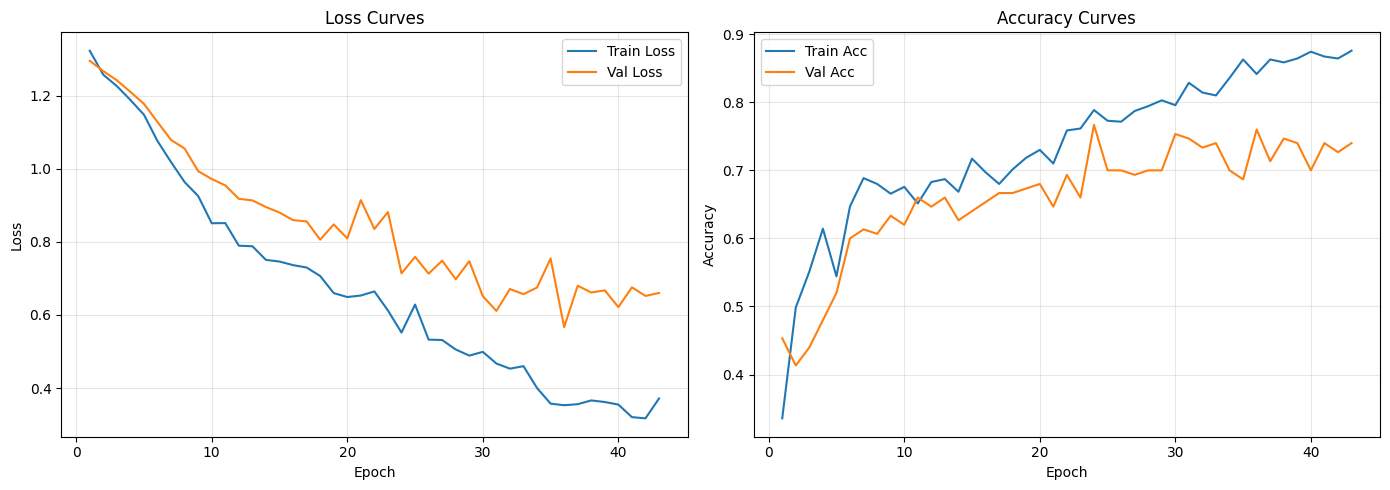

Training history saved.


In [44]:
from utils.evaluation import plot_training_curves

plot_training_curves(history)

# Save history for Notebook 3
import json
with open(os.path.join(TRANSFORMED, 'training_history.json'), 'w') as f:
    json.dump(history, f)
print('Training history saved.')

## Quick Test-Set Check

In [45]:
test_loss, test_acc = validate(model, test_loader, criterion, DEVICE)
print(f'Test Loss: {test_loss:.4f}  |  Test Accuracy: {test_acc:.4f}')

Test Loss: 0.7110  |  Test Accuracy: 0.8267
